In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import gc
import os

# tiff file i/o
import tifffile
from pyometiff import OMETIFFReader
from pyometiff import OMETIFFWriter


In [2]:
file_name = 'RE_IBD_20221220_BU19-11283-5-1_BU19-11283-5_Scan1.ome.tiff'

In [3]:
# # Load image data (into memory)
# img = imread("data/" + file_name)

In [4]:
# Read OME TIFF file using pyometiff 
reader = OMETIFFReader(fpath="data/" + file_name)

img, metadata, xml_metadata = reader.read()

del reader

Key not found: 'NoneType' object has no attribute 'iter'
key not found 'NoneType' object has no attribute 'iter'


In [5]:
# # view 1 image
# #img = io.imread(files[-1])
# plt.figure(figsize=(2,2))
# plt.imshow(imgs[0])
# plt.axis('off')
# plt.show()

In [6]:
img.shape

(7, 59040, 38400)

In [7]:
# plt.imshow(imgs[0][3,2000:3000,2000:3000])
# plt.show()

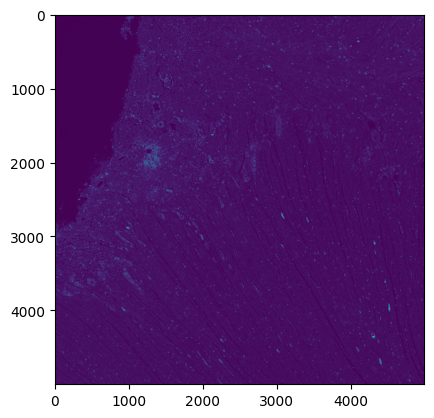

In [8]:
# Render parts of iamge to ensure that it has been loaded
channel = 2
plt.imshow(img[channel, 10000:15000, 10000:15000])
plt.show()

In [9]:
# smoothing kernel of autoflourescence
autoflour_average = cv2.blur(img[6, :, :], (3, 3))

In [10]:
# Subtract autoflourescence channel, avoiding clipping by integer overflow
autoflour_factor = 1.5
dapi_corrected = img[0, :, :] - np.minimum(autoflour_factor * autoflour_average, img[0, :, :])

Text(0.5, 1.0, 'DAPI - 1.5 * AF')

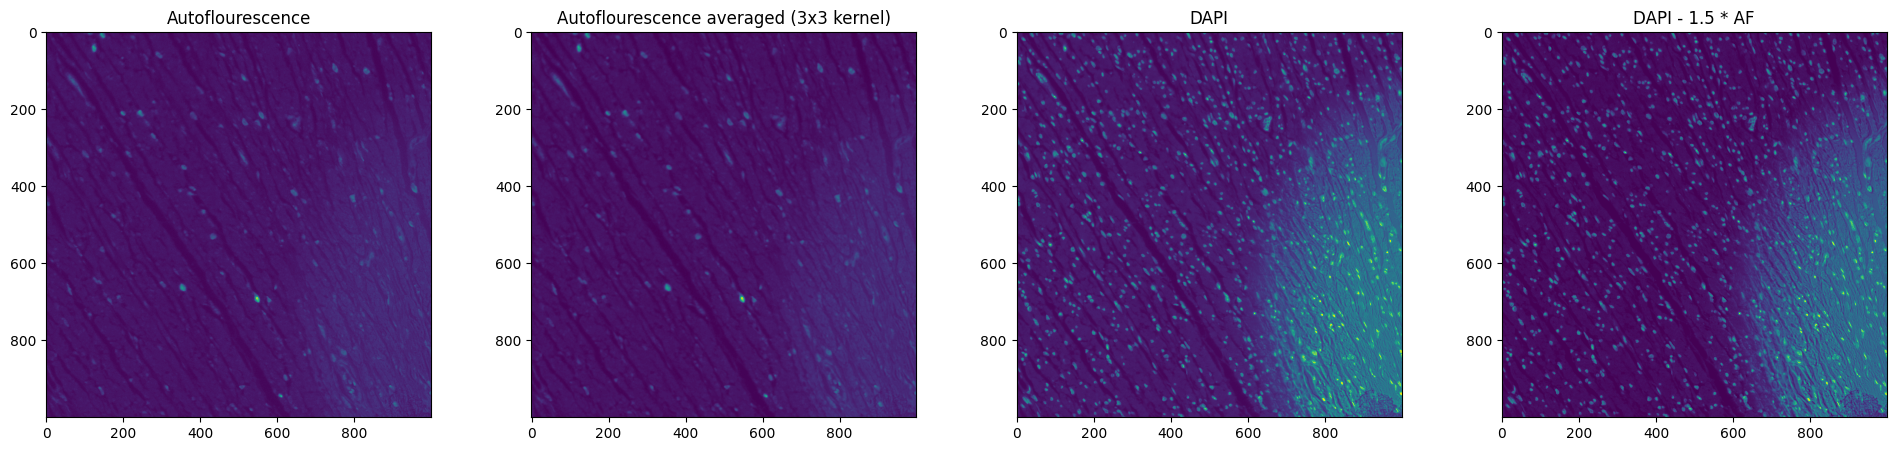

In [11]:
# Original autoflourescence channel
#x_view = slice(13500, 14000)
#y_view = slice(13500, 14000)

x_view = slice(13000, 14000)
y_view = slice(13000, 14000)

plt.rcParams['figure.figsize'] = [24, 5]

fig, axs = plt.subplots(1, 4)

#plt.imshow(imgs[0][6, x_view, y_view])
axs[0].imshow(img[6, x_view, y_view])
axs[0].set_title("Autoflourescence")

# Averaged
axs[1].imshow(autoflour_average[x_view, y_view])
axs[1].set_title("Autoflourescence averaged (3x3 kernel)")

# Corresponding DAPI
axs[2].imshow(img[0, x_view, y_view], )
axs[2].set_title("DAPI")

axs[3].imshow(dapi_corrected[x_view, y_view], )
axs[3].set_title(f"DAPI - {autoflour_factor} * AF")


In [12]:
# Memory management of temporary variables
del dapi_corrected

In [13]:
# Compute max projection of T cell cytoplasm markers, before adjustment
# this variable is overwritten later in the script
im_max = np.max(img[[1, 3, 4, 5], :, :], axis=0)


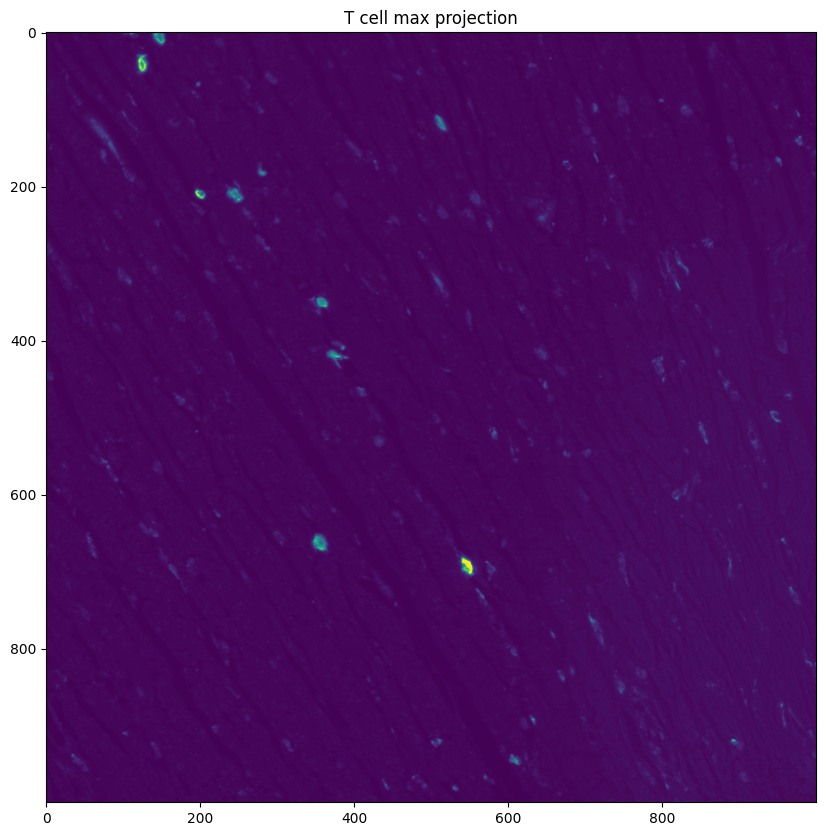

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(im_max[x_view, y_view])
plt.title("T cell max projection")
plt.show()

In [15]:
# Adjust images for autoflourescence in place
# WARNING: this will overwrite data used as input for calculations done above.

#autoflour_factors = [1.5, 0.5, 1, 0.5, 1, 0.5]  # v2
#autoflour_factors = [1.5, 0.5, 1, 0.5, 0.5, 0.5]  # v3

autoflour_factors = [1.5, 0.5, 1, 0.25, 0.25, 0.25]  # v1

for k in range(6):
    gc.collect()
    # 0 to 5
    img[k, :, :] = img[k, :, :] - np.minimum(autoflour_factors[k] * autoflour_average, img[k, :, :])


In [16]:
img.shape

(7, 59040, 38400)

In [17]:
# Compute max projection of T cell cytoplasm markers
im_max = np.max(img[[1, 3, 4, 5], :, :], axis=0)


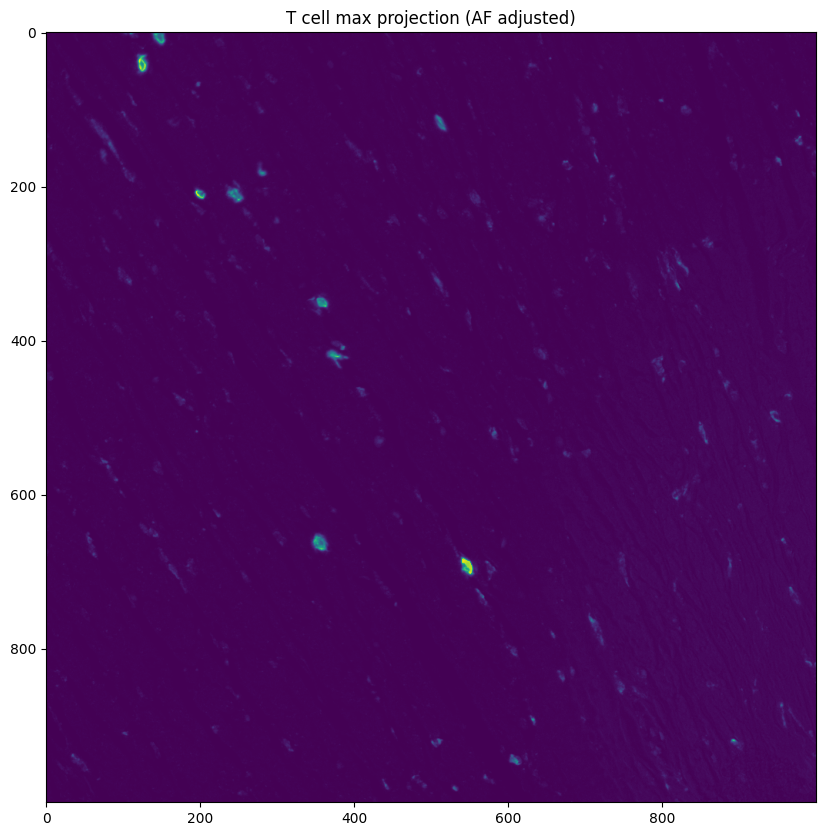

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(im_max[x_view, y_view])
plt.title("T cell max projection (AF adjusted)")
plt.show()

In [19]:
# Append T cell max projection channel
img = np.append(img, im_max[None, :, :], axis=0)

In [20]:
metadata

{'Directory': 'data',
 'Filename': 'RE_IBD_20221220_BU19-11283-5-1_BU19-11283-5_Scan1.ome.tiff',
 'Extension': 'ome.tiff',
 'ImageType': 'ometiff',
 'TotalSeries': 4,
 'SizeX': 38400,
 'SizeY': 59040,
 'SizeZ': 1,
 'SizeC': 7,
 'SizeT': 1,
 'SizeS': 1,
 'SizeB': 1,
 'SizeM': 1,
 'PhysicalSizeX': 0.4983437248734626,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.4983437248734626,
 'PhysicalSizeYUnit': 'µm',
 'Sizes BF': [4, 1, 1, 7, 59040, 38400],
 'DimOrder BF': 'XYZCT',
 'DimOrder BF Array': 'TCZYX',
 'ObjMag': '10.0',
 'ObjID': 'Objective:0:0',
 'InstrumentID': 'Instrument:0',
 'Channels': {'DAPI': {'Name': 'DAPI',
   'ID': 'Channel:0:0',
   'SamplesPerPixel': 1,
   'Color': '65535'},
  'Opal 570': {'Name': 'Opal 570',
   'ID': 'Channel:0:1',
   'SamplesPerPixel': 1,
   'Color': '-65281'},
  'Opal 690': {'Name': 'Opal 690',
   'ID': 'Channel:0:2',
   'SamplesPerPixel': 1,
   'Color': '-16776961'},
  'Opal 480': {'Name': 'Opal 480',
   'ID': 'Channel:0:3',
   'SamplesPerPixel': 1,
  

In [21]:
# Add new corresponding metadata for added channel
metadata_new = metadata

metadata_new['SizeC'] = metadata['SizeC'] + 1

metadata_new['Channels']['Max project'] = {
    'Name': 'T cell max project',
    'ID': 'Channel:0:7',
    'SamplesPerPixel': 1,
    'Color': '255'
}

In [22]:
# Copy specified fields in metadata dict 
metadata_new_subset = {
    key: metadata_new[key] for key in [
        'Channels', 'SizeC','PhysicalSizeX', 'PhysicalSizeXUnit', 'PhysicalSizeY', 'PhysicalSizeYUnit'
    ]
}

In [23]:
os.makedirs("data/adjust", exist_ok=True)

In [24]:
img.shape

(8, 59040, 38400)

In [25]:
metadata_new_subset

{'Channels': {'DAPI': {'Name': 'DAPI',
   'ID': 'Channel:0:0',
   'SamplesPerPixel': 1,
   'Color': '65535'},
  'Opal 570': {'Name': 'Opal 570',
   'ID': 'Channel:0:1',
   'SamplesPerPixel': 1,
   'Color': '-65281'},
  'Opal 690': {'Name': 'Opal 690',
   'ID': 'Channel:0:2',
   'SamplesPerPixel': 1,
   'Color': '-16776961'},
  'Opal 480': {'Name': 'Opal 480',
   'ID': 'Channel:0:3',
   'SamplesPerPixel': 1,
   'Color': '16777215'},
  'Opal 620': {'Name': 'Opal 620',
   'ID': 'Channel:0:4',
   'SamplesPerPixel': 1,
   'Color': '-8388353'},
  'Opal 520': {'Name': 'Opal 520',
   'ID': 'Channel:0:5',
   'SamplesPerPixel': 1,
   'Color': '16711935'},
  'Sample AF': {'Name': 'Sample AF',
   'ID': 'Channel:0:6',
   'SamplesPerPixel': 1,
   'Color': '255'},
  'Max project': {'Name': 'T cell max project',
   'ID': 'Channel:0:7',
   'SamplesPerPixel': 1,
   'Color': '255'}},
 'SizeC': 8,
 'PhysicalSizeX': 0.4983437248734626,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.4983437248734626,
 'Phy

In [26]:
# Write file as pyrimidal tiff for reading with QuPath
# Adopted from https://gist.github.com/bpavie/8d97f753c4d83860bcffca7da230e9a0
# And tifffile author guidance at:
# https://forum.image.sc/t/creating-a-multi-channel-pyramid-ome-tiff-with-tiffwriter-in-python/76424/3

from tifffile import TiffWriter

image = img  # copy image object which is downsampled during writing

# get image dimensions
channels, height, width = image.shape

# transpose dimensions such that cv2.resize works implicitly on multiple channels
image = image.transpose((1, 2, 0))  # height x width x channels

# Number of pyramidal renders 
subifds = 8

# Get pixel dimension from metadata
umPerPix = (metadata['PhysicalSizeX'], metadata['PhysicalSizeY'])

with TiffWriter("data/adjust/" + file_name, bigtiff=True, ome=True) as tif:
    for level in range(subifds + 1):  # pyramid rendering levels, first iteration declares number of expected subifds
        print("level:", level, ", width:", width, ", height:", height)
        tif.write(
            image.transpose((2, 0, 1)),  # reshapes written data back into channels x height x width
            software='Glencoe/Faas pyramid',
            metadata=metadata_new_subset,
            resolution = [10000/umPerPix[0]/2**level, 10000/umPerPix[1]/2**level, 'CENTIMETER'],
            compression='zlib',
            # Logic handling pyramidal renders
            subifds=subifds if level == 0 else None,  # opens a branch in the IFD tree, which is closed (going back to the main IFD chain) after n SubIFDs have been written
            subfiletype=1 if level else 0,
        )
        
        # Downsample image resolution
        width //= 2
        height //= 2
        image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

level: 0 , width: 38400 , height: 59040
level: 1 , width: 19200 , height: 29520
level: 2 , width: 9600 , height: 14760
level: 3 , width: 4800 , height: 7380
level: 4 , width: 2400 , height: 3690
level: 5 , width: 1200 , height: 1845
level: 6 , width: 600 , height: 922
level: 7 , width: 300 , height: 461
level: 8 , width: 150 , height: 230
